In [1]:
import cytoflow as flow
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib
import scipy.stats as stats
import scipy as sp
from scipy.stats.mstats import gmean
import scipy.optimize as opt
import numpy as np
from numpy import median
matplotlib.rc('figure', dpi = 160)

# Import samples and specify experimental condtions

In [2]:
#inputs = pd.read_csv('out.csv',header=None)
#inputs.columns = ['filename', 'ahl', 'iptg', 'family']
inputs =pd.read_excel('LuxR updated.xls',sheet_name='LuxR')

sets the conditions of the tube

In [3]:


       
tubes = []
for i in inputs.iterrows():
    filename =i[1].filename
    ahl = i[1].AHL
    iptg = i[1].IPTG
    family = i[1].Family
    tubes.append(flow.Tube(file = 'data/' + filename + '.fcs', conditions = {'AHL' : ahl, 'IPTG' : iptg, 'Family' : family}))
    
ex = flow.ImportOp(conditions = {'AHL' : 'float', 'IPTG' : 'float', 'Family' : 'str'},
                   tubes = tubes).apply()
       


In [4]:
flow.set_default_scale("log")

# Plot FITC-A histograms for all IPTG and AHL induction conditions

C:\Users\Jonathan\anaconda3\envs\cf2\lib\site-packages\cytoflow\utility\log_scale.py:117: RuntimeWarning: invalid value encountered in log10


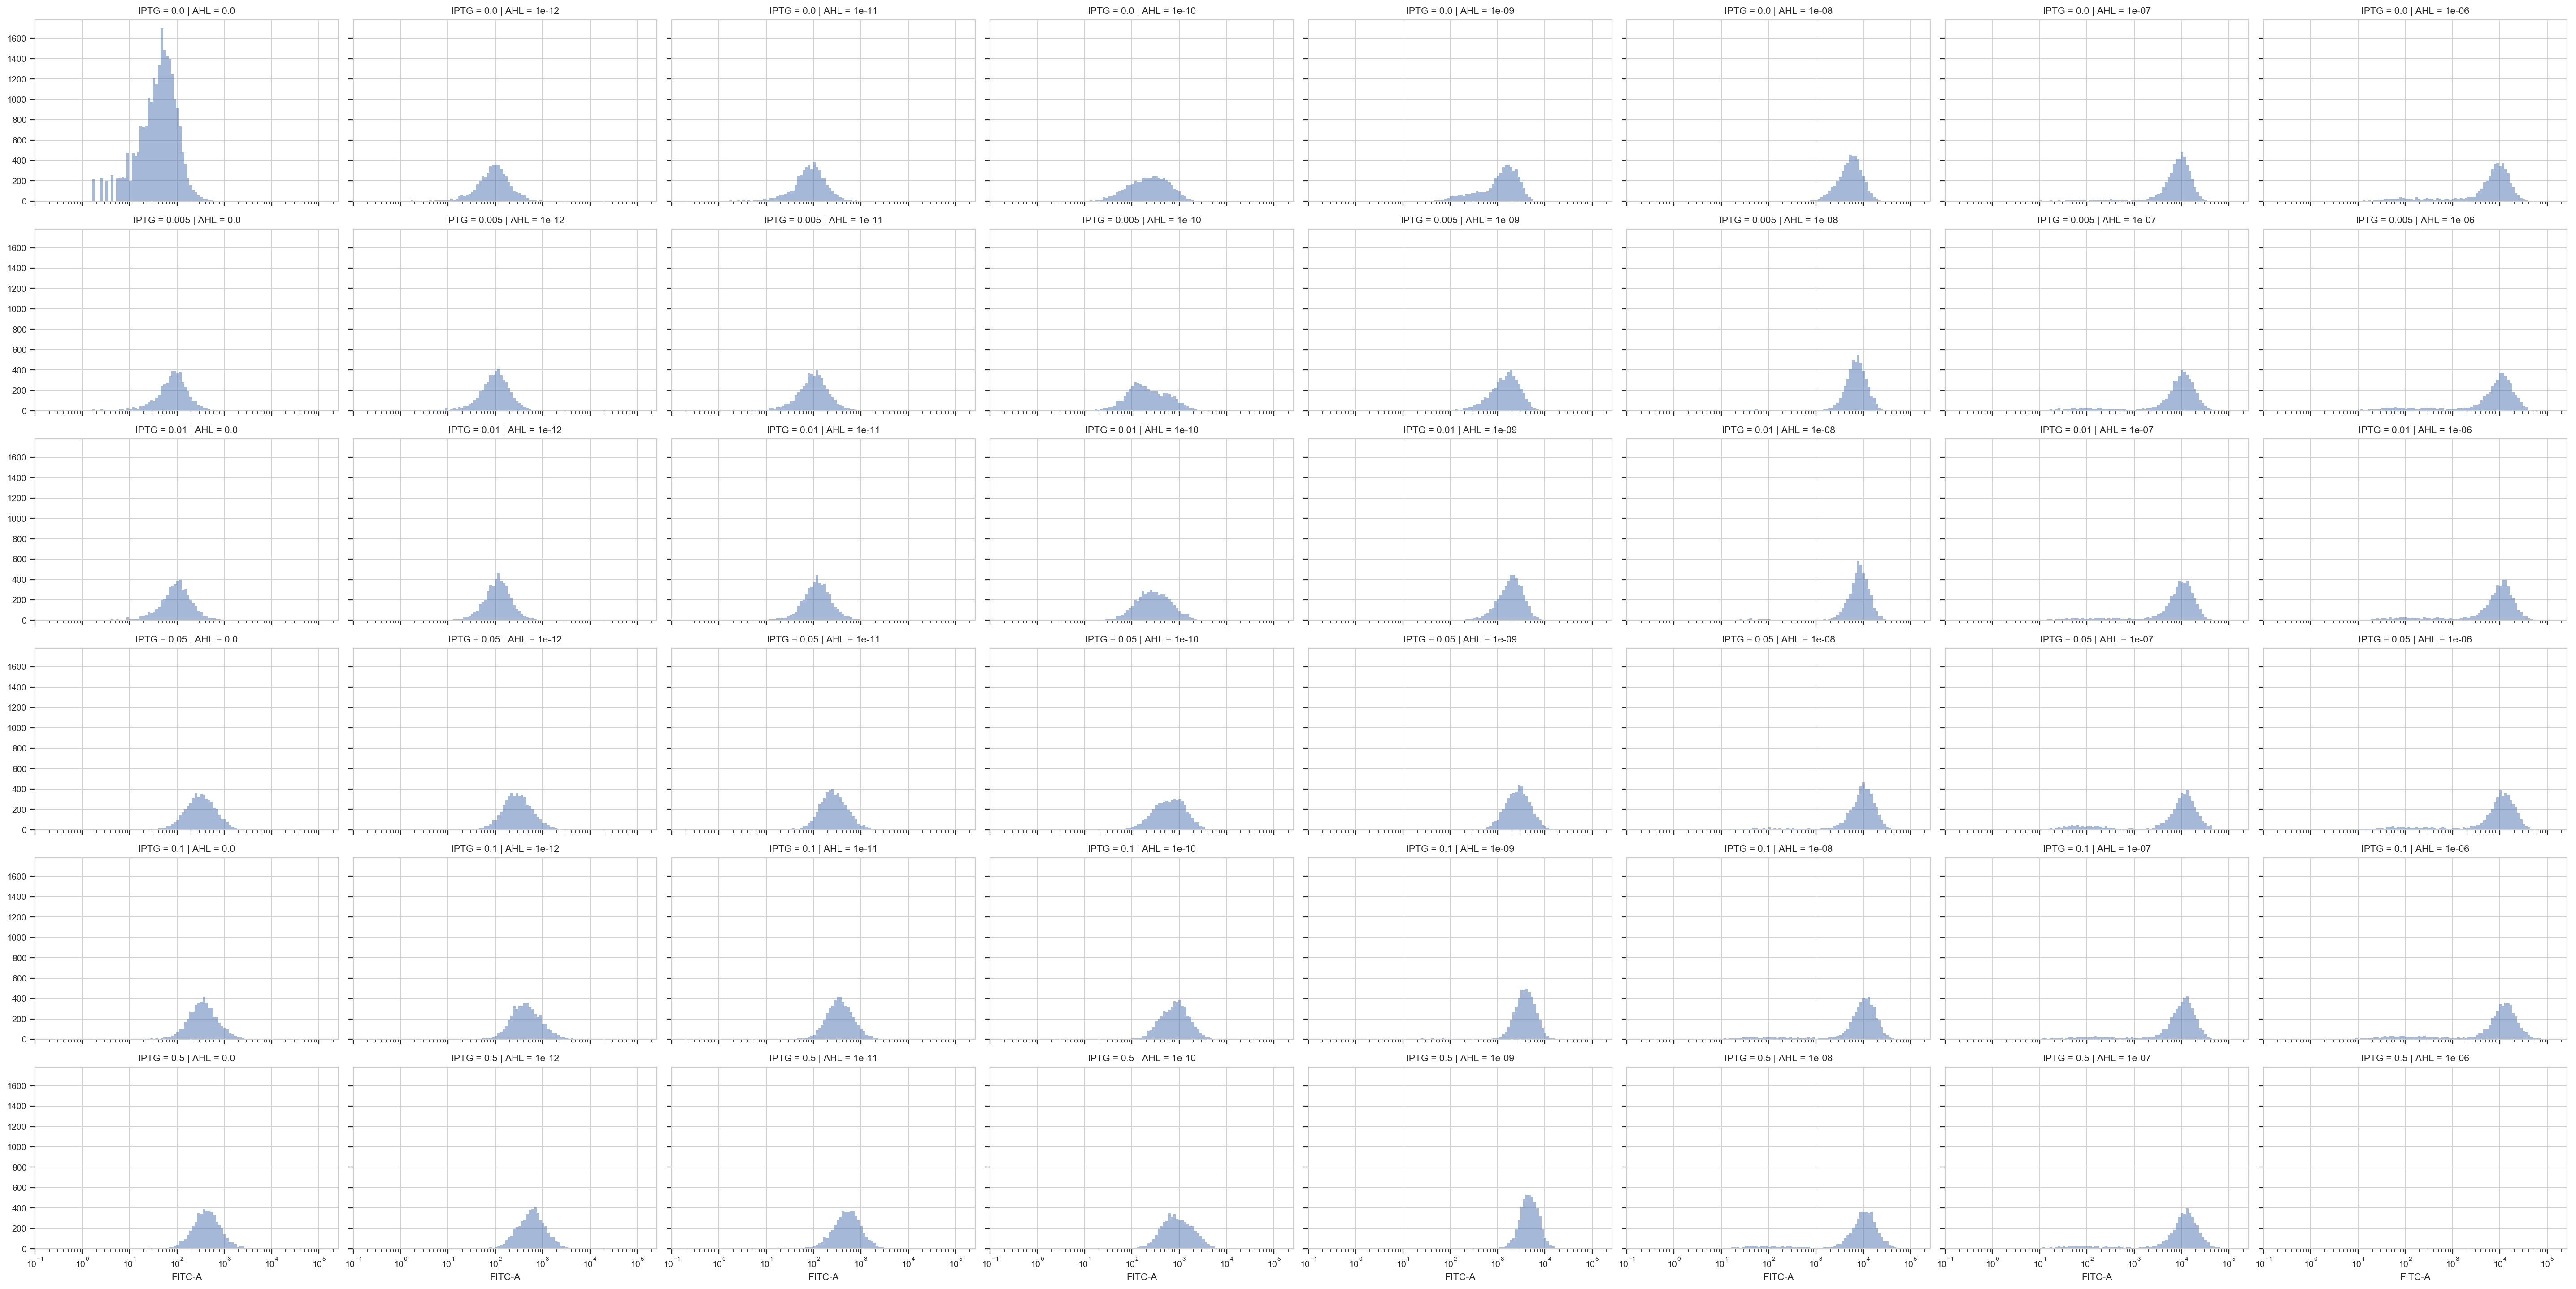

In [5]:

flow.HistogramView(channel = "FITC-A",
                   xfacet = "AHL",
                  yfacet = 'IPTG').plot(ex)

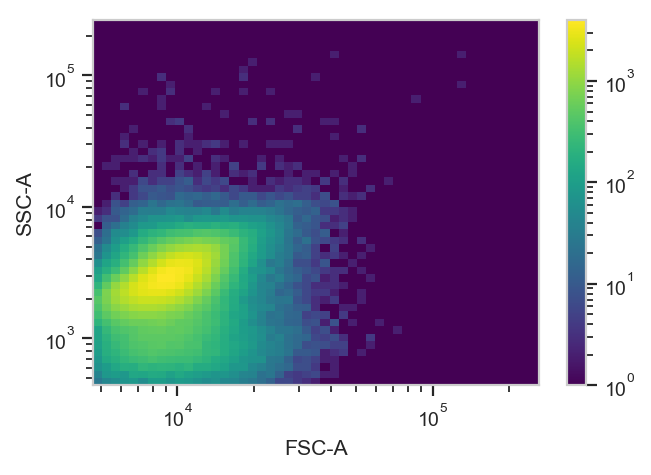

In [6]:
flow.DensityView(xchannel = "FSC-A", 
                 ychannel = "SSC-A",
                 xscale = 'log',
                 yscale = 'log').plot(ex, min_quantile = 0.005)

# Singlet gating to remove doublets

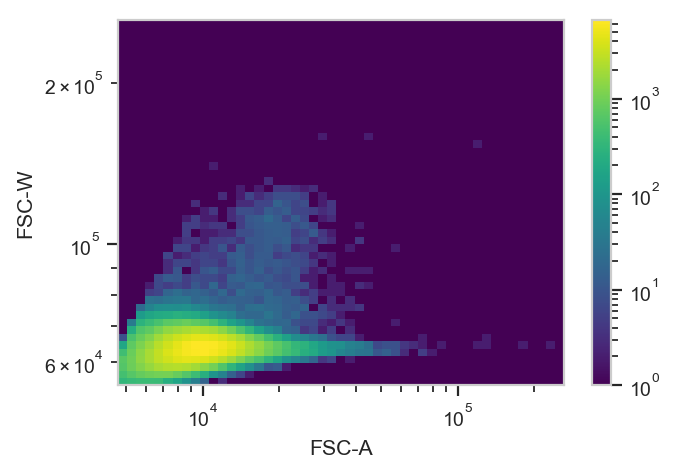

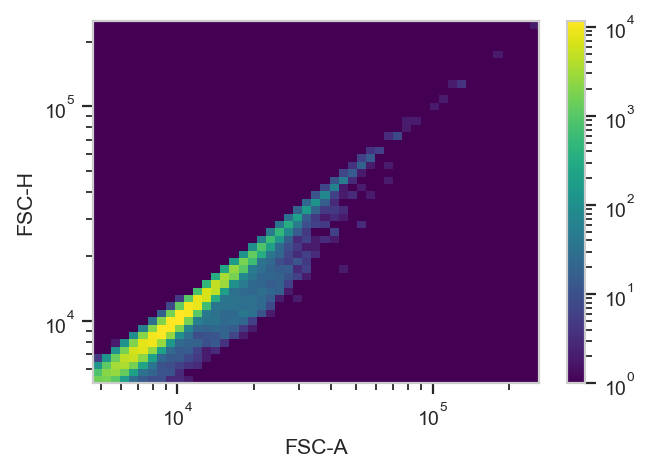

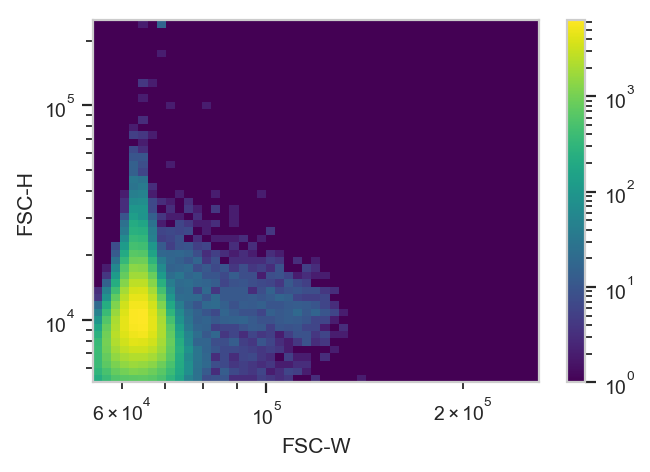

In [7]:

#channels = ['FSC-A','FSC-W','FSC-H','SSC-A','SSC-W','SSC-H']
#perm = combinations(channels,2)
FSC = [('FSC-A','FSC-W'),('FSC-A','FSC-H'),('FSC-W','FSC-H')]

#f, axes = plt.subplots(ncols=4,nrows=4)
#axs = axes.ravel()
for i,(x,y) in enumerate(FSC):  
    flow.DensityView(xchannel = x, 
                ychannel = y,
                xscale = 'log',
                yscale = 'log').plot(ex, min_quantile = 0.005)


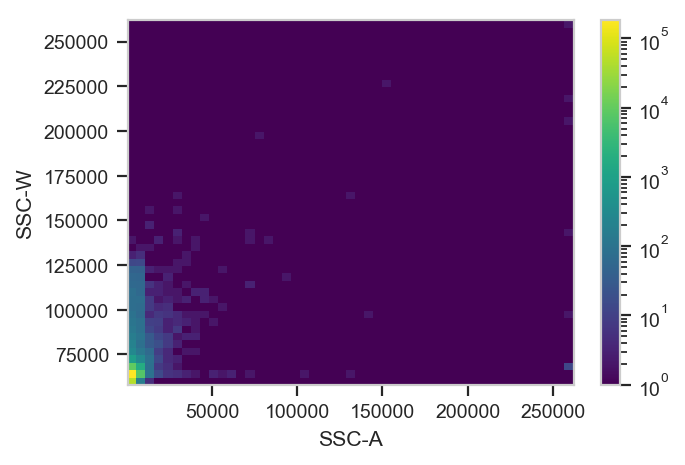

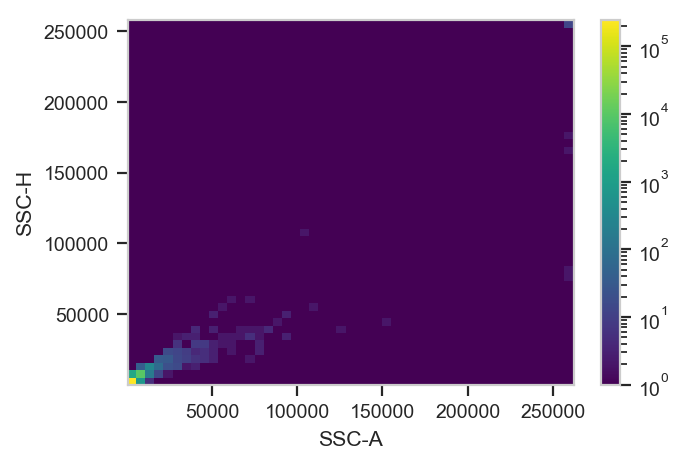

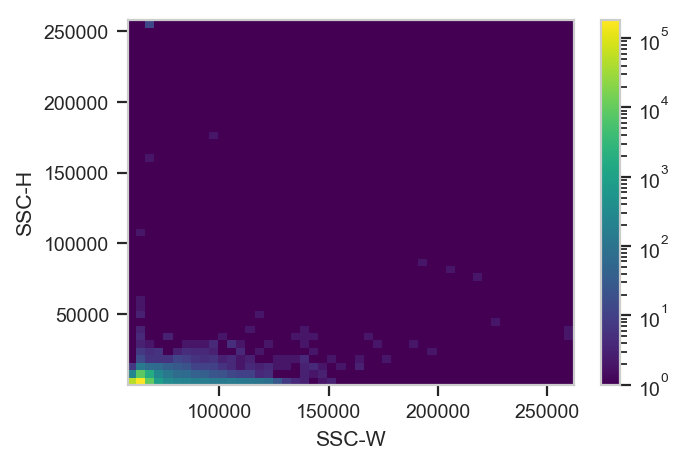

In [8]:
SSC = [('SSC-A','SSC-W'),('SSC-A','SSC-H'),('SSC-W','SSC-H')]
for i,(x,y) in enumerate(SSC):  
    flow.DensityView(xchannel = x, 
                ychannel = y,
                xscale = 'linear',
                yscale = 'linear').plot(ex, min_quantile = 0.005)

## Create and store singlet gate

saves the single data as ex2

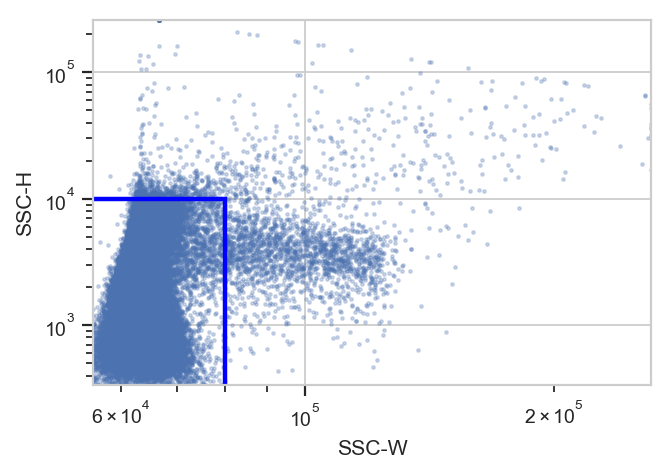

In [9]:
r = flow.Range2DOp(name = "Range2D",
                   xchannel = "SSC-W",
                   xlow = 55000,
                   xhigh = 80000,
                   ychannel = "SSC-H",
                   ylow = 100,
                   yhigh = 10000)
                   
rv = r.default_view(xscale ='log',yscale='log')

rv.plot(ex)
ex2 = r.apply(ex)

## Use a gaussian mixture model to further gate the population

C:\Users\Jonathan\anaconda3\envs\cf2\lib\site-packages\cytoflow\utility\log_scale.py:117: RuntimeWarning: invalid value encountered in log10
C:\Users\Jonathan\anaconda3\envs\cf2\lib\site-packages\cytoflow\operations\gaussian.py:529: RuntimeWarning: invalid value encountered in less_equal
C:\Users\Jonathan\anaconda3\envs\cf2\lib\site-packages\cytoflow\operations\base_op_views.py:342: CytoflowViewWarning: Setting 'huefacet' to 'GM_1'


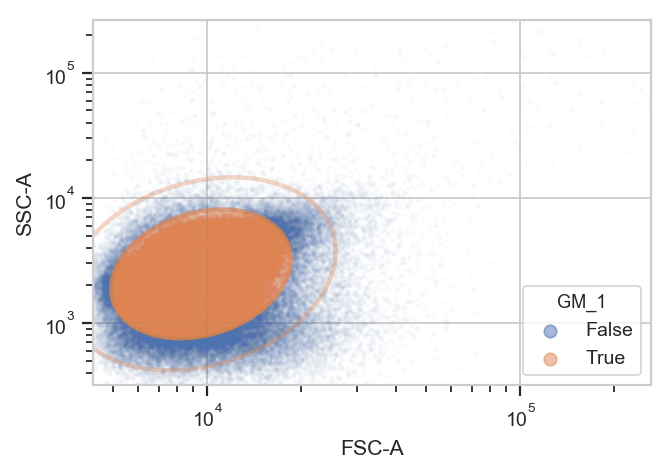

In [10]:
gm = flow.GaussianMixtureOp(name = "GM",
                            channels = ['FSC-A', 'SSC-A'],
                            scale = {'FSC-A' : 'log',
                                     'SSC-A' : 'log'},
                            num_components = 1,
                            sigma = 2)
gm.estimate(ex2)
ex_gm = gm.apply(ex2)
gm.default_view().plot(ex_gm, alpha = 0.02)

C:\Users\Jonathan\anaconda3\envs\cf2\lib\site-packages\cytoflow\utility\log_scale.py:117: RuntimeWarning: invalid value encountered in log10
C:\Users\Jonathan\anaconda3\envs\cf2\lib\site-packages\cytoflow\operations\gaussian.py:529: RuntimeWarning: invalid value encountered in less_equal
C:\Users\Jonathan\anaconda3\envs\cf2\lib\site-packages\cytoflow\operations\base_op_views.py:342: CytoflowViewWarning: Setting 'huefacet' to 'GM3_1'


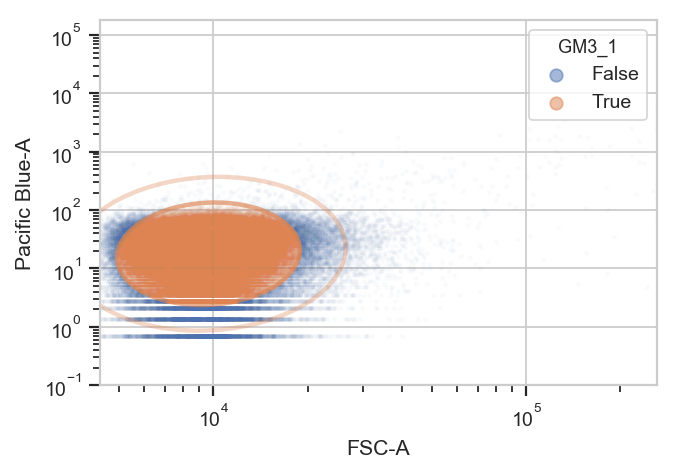

In [11]:
gm3 = flow.GaussianMixtureOp(name = "GM3",
                            channels = ['FSC-A', 'Pacific Blue-A'],
                            scale = {'FSC-A' : 'log',
                                     'Pacific Blue-A' : 'log'},
                            num_components = 1,
                            sigma = 2)
gm3.estimate(ex_gm)
ex_gm2 = gm3.apply(ex_gm)
gm3.default_view().plot(ex_gm2, alpha = 0.02)

In [12]:
df =ex_gm2.data

take the stuff from cytoflow and changing it to datatframe

# filter out events that don't fall within the gates

In [13]:

df = df[(df.GM_1==True) & (df.GM3_1==True) & (df.Range2D==True) & (df['FITC-A'] >0)]
df

,AHL,FITC-A,FITC-H,FITC-W,FSC-A,FSC-H,FSC-W,Family,IPTG,Pacific Blue-A,Pacific Blue-H,Pacific Blue-W,SSC-A,SSC-H,SSC-W,Time,Range2D,GM_1,GM3_1
1,0.0,22.620001,33.0,44921.953125,7454.160156,8213.0,59480.800781,#681,0.0,2.760000,56.0,3229.988281,2256.780029,2437.0,60689.515625,52.299999,True,True,True
3,0.0,24.360001,33.0,48377.488281,13035.600586,12853.0,66467.062500,#681,0.0,28.289999,73.0,25397.445312,4113.359863,4337.0,62156.597656,52.299999,True,True,True
14,0.0,4.350000,42.0,6787.657227,9468.720703,9390.0,66085.429688,#681,0.0,32.430000,73.0,29114.144531,3029.340088,3182.0,62391.839844,52.500000,True,True,True
16,0.0,9.570000,56.0,11199.634766,12560.400391,12924.0,63692.226562,#681,0.0,83.489998,40.0,136790.015625,4038.540039,4284.0,61780.996094,52.500000,True,True,True
18,0.0,19.139999,32.0,39198.718750,13128.480469,13376.0,64323.273438,#681,0.0,11.730000,60.0,12812.287109,5181.720215,5331.0,63700.847656,52.599998,True,True,True
22,0.0,50.459999,40.0,82673.656250,6548.400391,6524.0,65781.117188,#681,0.0,8.970000,72.0,8164.693848,2342.040039,2472.0,62090.593750,52.599998,True,True,True
25,0.0,38.279999,41.0,61188.242188,5864.400391,5757.0,66758.625000,#681,0.0,26.219999,32.0,53698.558594,3980.250000,4013.0,65001.160156,52.599998,True,True,True
27,0.0,41.760002,36.0,76021.765625,10982.160156,10880.0,66151.359375,#681,0.0,30.360001,62.0,32091.500000,3769.709961,3876.0,63738.832031,52.700001,True,True,True
30,0.0,7.830000,39.0,13157.612305,13356.000977,14035.0,62365.433594,#681,0.0,75.900002,77.0,64599.777344,1147.530029,1159.0,64887.425781,52.700001,True,True,True
33,0.0,60.900002,56.0,71270.406250,14235.120117,15244.0,61198.691406,#681,0.0,21.389999,33.0,42479.238281,1663.440063,1688.0,64582.468750,52.799999,True,True,True


In [14]:
df.columns 



Index(['AHL', 'FITC-A', 'FITC-H', 'FITC-W', 'FSC-A', 'FSC-H', 'FSC-W',
       'Family', 'IPTG', 'Pacific Blue-A', 'Pacific Blue-H', 'Pacific Blue-W',
       'SSC-A', 'SSC-H', 'SSC-W', 'Time', 'Range2D', 'GM_1', 'GM3_1'],
      dtype='object')

In [26]:
import os
for x in os.listdir():
    if x.endswith(".ipynb"):
        # Prints only text file present in My Folder
        nb_name = x
        Replicate = nb_name.split('-')[1][:1]
        fam = nb_name.split('-')[0]


Lux


In [27]:
data = df[['FITC-A','AHL','IPTG','Family']]
data.insert(4,'Replicate',Replicate)
if fam == 'Lux':
    data.to_pickle(f'../../../../compiled-data/ec/lux/{fam}_{Replicate}.pkl')
elif fam == 'Las':
    data.to_pickle(f'../../../../compiled-data/ec/las/{fam}_{Replicate}.pkl')
if fam == 'Tra':
    data.to_pickle(f'../../../../compiled-data/ec/tra/{fam}_{Replicate}.pkl')


In [32]:
# Subtract WT background from samples
data = df[['FITC-A','AHL','IPTG','Family']]
data['FITC-A'] = data['FITC-A'] - data[data.Family=='#681']['FITC-A'].median()
data['FITC-A'] = data[data['FITC-A'] > 0]['FITC-A']
data = data[data.Family=='LuxR']
data.drop('Family',inplace=True,axis=1)

C:\Users\Jonathan\anaconda3\envs\cf2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Jonathan\anaconda3\envs\cf2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [33]:
data['FITC-A'].min()

0.8700008392333984

In [34]:
data

,FITC-A,AHL,IPTG
20000,83.520002,0.0,0.0
20004,NaN,0.0,0.0
20005,NaN,0.0,0.0
20008,34.800001,0.0,0.0
20012,58.289999,0.0,0.0
20013,27.840002,0.0,0.0
20014,229.679998,0.0,0.0
20015,118.319998,0.0,0.0
20021,NaN,0.0,0.0
20022,0.870001,0.0,0.0


# Plot median FITC-A

use median or geometeric mean 

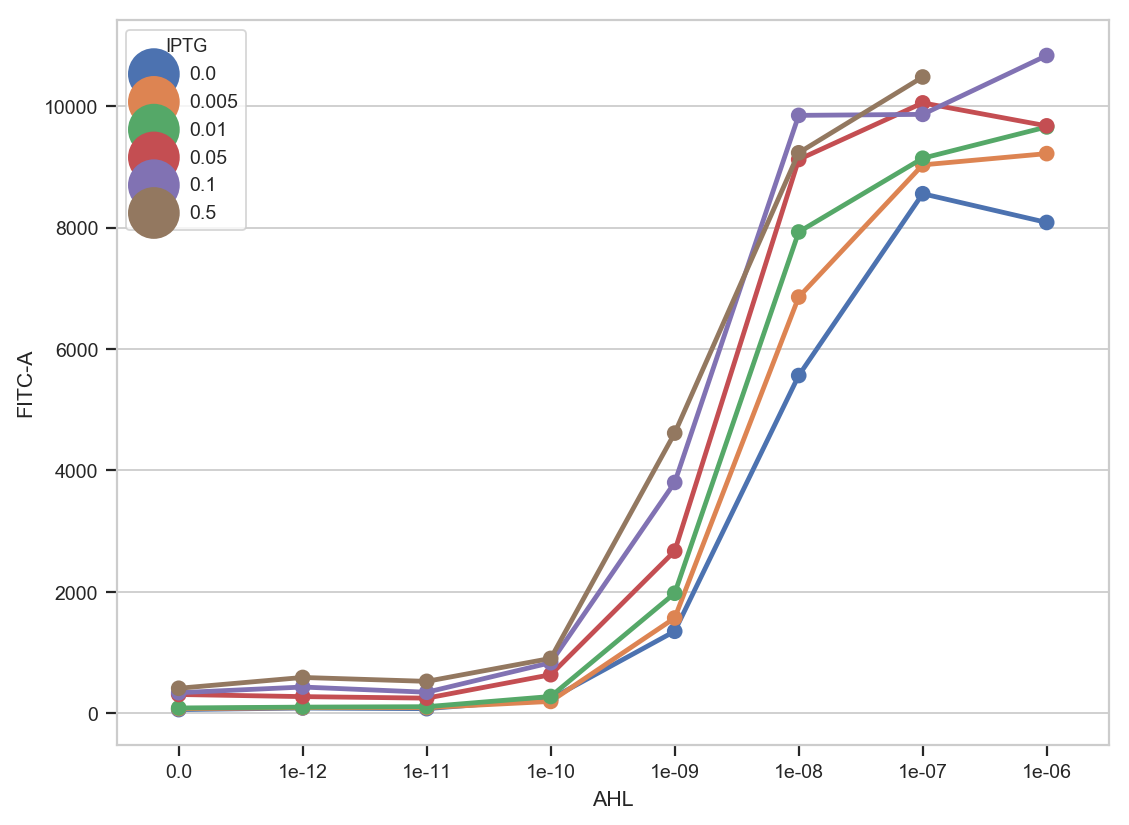

In [36]:
mfi = data.groupby(['AHL','IPTG'])['FITC-A'].median().reset_index()

f, ax = plt.subplots(figsize=(8,6))
sns.pointplot(x='AHL',y='FITC-A',hue='IPTG',data=mfi)
#f.savefig('LuxR.png',dpi=600)

# Plot heatmaps showing absolute and relative induction

Raw signal 

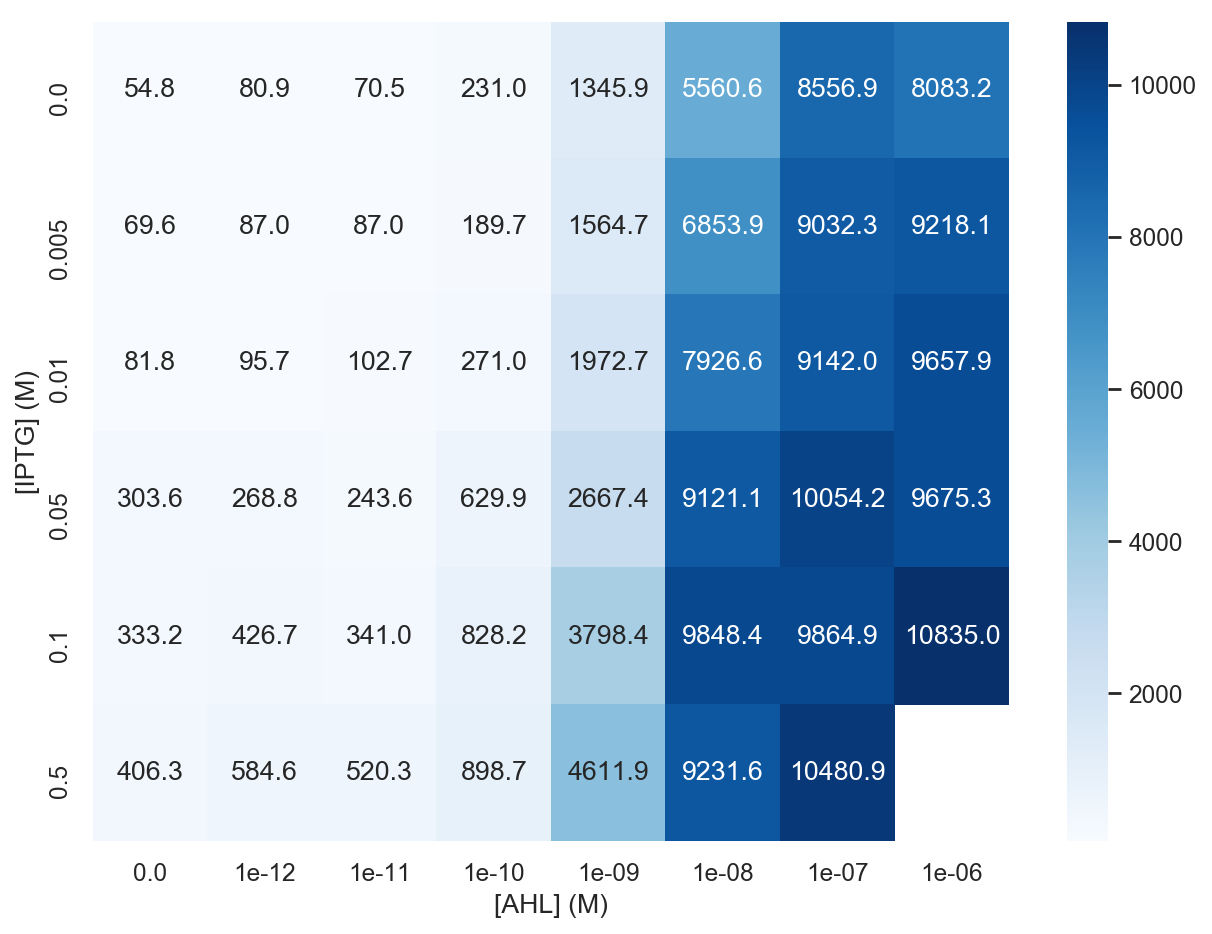

In [37]:
sns.set(style="white")
f, ax = plt.subplots(figsize=(8,6))


piv = mfi.pivot_table(index='IPTG', columns='AHL', values='FITC-A')
g = sns.heatmap(piv, annot=True, fmt=".1f",cmap='Blues')
cbar = g.collections[0].colorbar
ax.set_xlabel(r'[AHL] (M)')
ax.set_ylabel(r'[IPTG] (M)')
f.tight_layout()

Normalized to highest signal 

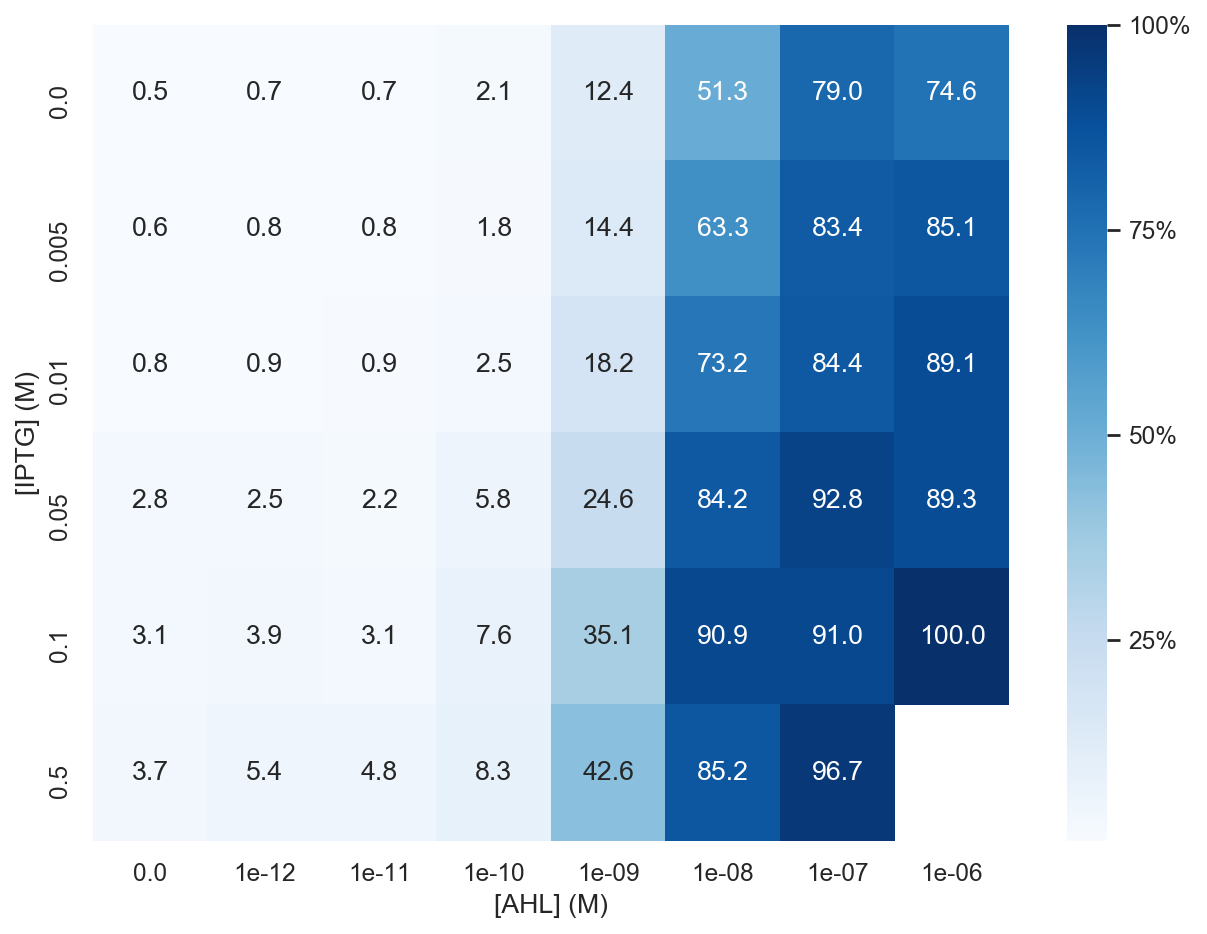

In [38]:
f, ax = plt.subplots(figsize=(8,6))
# normalized
norm = mfi.copy()
norm['FITC-A']=norm['FITC-A']/norm['FITC-A'].max()*100

piv = norm.pivot_table(index='IPTG', columns='AHL', values='FITC-A')
g = sns.heatmap(piv, annot=True, fmt=".1f",cmap='Blues')
cbar = g.collections[0].colorbar
cbar.set_ticks([0, 25, 50, 75,100])
cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
ax.set_xlabel(r'[AHL] (M)')
ax.set_ylabel(r'[IPTG] (M)')
f.tight_layout()

# Calculate the on/off ratio and plot

In [39]:

R =[]
for i in mfi.IPTG.unique():
    tmp = mfi[mfi.IPTG ==i]['FITC-A'].max()/mfi[mfi.IPTG ==i]['FITC-A'].min()
    R.append([i,tmp])



In [40]:

R = pd.DataFrame(R,columns=['IPTG','Induction Ratio'])
R

,IPTG,Induction Ratio
0,0.000,156.119038
1,0.005,132.443745
2,0.010,118.095742
3,0.050,41.273215
4,0.100,32.516969
5,0.500,25.796574


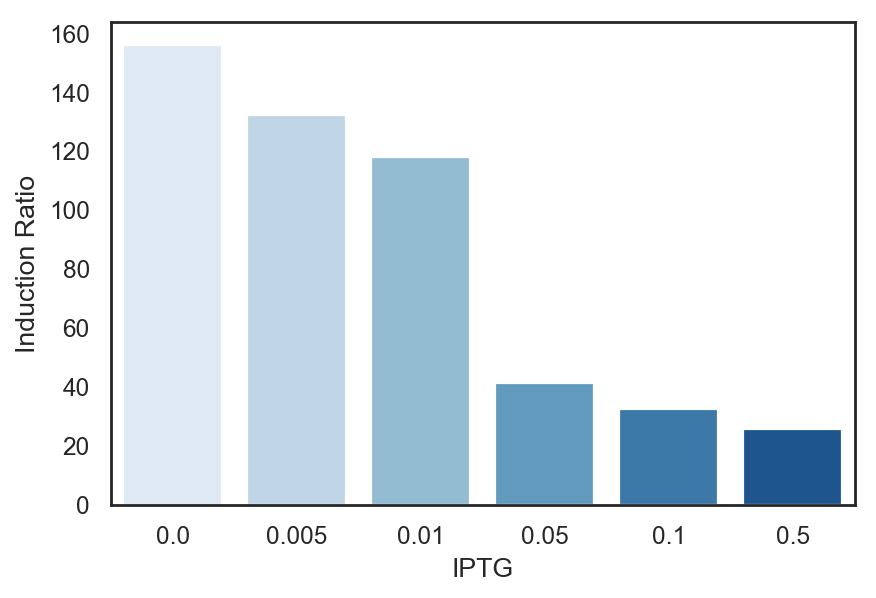

In [41]:
f, ax  = plt.subplots()
sns.barplot(x='IPTG',y='Induction Ratio',data=R,palette='Blues')

STOP HERE